## Topic: Nashville Traffic Accidents
### Goal: Principal Component Analysis, K-Means Clustering, & GeoSpatial Mapping

**Environment Details**: 
- **OS**: Debian Linux 12 (x86_64)
- **Python version**: 3.11.2
- **Jupyter-Lab version**: 4.1.5
***

## Table of Contents

0. [Pre-task setup](#Pre-task-setup)
1. [Dataset Selection](#1.-Dataset-Selection)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Model Selection](#3.-Model-Selection)
4. [Exploratory Data Analysis](#4.-Exploratory-Data-Analysis)
5. [Model Creation](#5.-Model-Creation)
6. [Results](#6.-Results)
7. [Discussion](#7.-Discussion)
8. [Citations](#8.-Citations)

***

### Pre-task setup
[top](#CSC-722:-Final-Project)

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn imports
from sklearn import metrics
from sklearn.cluster import KMeans

# Elbow visualization
from yellowbrick.cluster import KElbowVisualizer

# Map visualizations
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from IPython.display import Image
%matplotlib inline

# Nicer Jupyter output formatting
import ipywidgets as widgets

# Quiet filter warnings
import warnings
warnings.filterwarnings('ignore')

***

### 1. Dataset Selection
[top](#CSC-722:-Final-Project)

#### 1.1. Goal
We need a dataset to help us answer this question:

**Where are the common hotspots in traffic accidents within the Nashville metropolitan area?**

#### 1.2. Dataset Information

This notebook uses a [Nashville Traffic Accident](https://data.nashville.gov/Police/Traffic-Accidents/6v6w-hpcw) dataset [1] from the Nashville Metropolitan Government's [Open Data repository](https://data.nashville.gov/).

This dataset contains over 200,000 records of traffic accidents in Nashville, Tennessee as recorded by the Metro Police Department. It contains interesting fields such as:
* Date and time of the accident
* Number of vehicles involved
* Number of injuries
* Number of fatalities
* A record of any property damage
* The weather conditions recorded during the accident
* Whether or not external illumination was present at the accident location
* The police precinct where the accident occurred
* Geographical coordinates of the accident location
* Whether or not a hit and run was involved in the accident

Additional fields and relevant datatypes for each field are available on the dataset's [metadata documentation](https://data.nashville.gov/api/views/6v6w-hpcw/files/3af9281b-fa4f-4044-83f8-1b9a46cc6e95?download=true&filename=Traffic-Accidents-Metadata-v2.pdf). [2]

The dataset is updated daily.  The dataset version used for this notebook is current as of **March 16, 2024**.

#### 1.3) Target Selection

**Target**:

Since we don't have a specific target variable, we'll do clustering and will choose an unsupervised learning model a bit later in this notebook.

#### 1.4) Data Loading

In [2]:
# Load our dataset into a Pandas dataframe
data = pd.read_csv('Traffic_Accidents.csv')

In [3]:
# Ensure our dat loaded correctly
data.head()

Accident Number          Date and Time  Number of Motor Vehicles  \
0      20210274292  May 17, 2021 06:42 PM                       2.0   
1      20210273720  May 17, 2021 01:13 PM                       2.0   
2      20210273098  May 17, 2021 06:44 AM                       2.0   
3      20210273673  May 17, 2021 12:35 PM                       2.0   
4      20210273706  May 17, 2021 01:02 PM                       2.0   

   Number of Injuries  Number of Fatalities Property Damage Hit and Run  \
0                   0                     0             NaN       False   
1                   0                     0             NaN       False   
2                   0                     0             NaN        True   
3                   0                     0             NaN        True   
4                   1                     0             NaN       False   

   Reporting Officer  Collision Type Code  Collision Type Description  ...  \
0           384403.0                  4.0                       ANGLE  ...   
1           902543.0                 11.0               Front to Rear  ...   
2           226622.0                  5.0  SIDESWIPE - SAME DIRECTION  ...   
3           462474.0                  5.0  SIDESWIPE - SAME DIRECTION  ...   
4           462474.0                  4.0                       ANGLE  ...   

          Harmful Description                      Street Address       City  \
0  MOTOR VEHICLE IN TRANSPORT  OLD HICKORY BLVD & NOLENSVILLE PKE    ANTIOCH   
1  MOTOR VEHICLE IN TRANSPORT             WEDGEWOOD AV & BEECH AV  NASHVILLE   
2  MOTOR VEHICLE IN TRANSPORT                        MM 2 9 I 440  NASHVILLE   
3  MOTOR VEHICLE IN TRANSPORT                        MM 79 7 I 65  NASHVILLE   
4  MOTOR VEHICLE IN TRANSPORT             WEDGEWOOD AV & BEECH AV  NASHVILLE   

  State      ZIP     RPA Precinct Latitude Longitude           Mapped Location  
0    TN  37013.0  8757.0    SOUTH  36.0455  -86.7122  POINT (-86.7122 36.0455)  
1    TN  37204.0  6919.0   MIDTOW  36.1343  -86.7806  POINT (-86.7806 36.1343)  
2    TN  37212.0  6506.0   MIDTOW  36.1208  -86.8029  POINT (-86.8029 36.1208)  
3    TN  37204.0  8504.0   MIDTOW  36.1092  -86.7698  POINT (-86.7698 36.1092)  
4    TN  37204.0  6919.0   MIDTOW  36.1343  -86.7806  POINT (-86.7806 36.1343)  

[5 rows x 25 columns]

In [4]:
# Check our data set's shape
data.shape

(181986, 25)

We have `181,364` observations and `25` features.

### 2. Data Preprocessing
[top](#CSC-722:-Final-Project)

#### 2.1. Dropping Unnecessary Features

**Proposed Features to Drop**

Based on the [dataset documentation](https://data.nashville.gov/api/views/6v6w-hpcw/files/3af9281b-fa4f-4044-83f8-1b9a46cc6e95?download=true&filename=Traffic-Accidents-Metadata-v2.pdf) [2], the following features don't appear to help us achieve our intended goal:
* Accident Number --> a unique accident identifier, not needed for training.
* Property Damage --> details about whether or not external property was damaged in the accident. Contains very few values, so dropping this feature entirely.
* Hit and Run --> details about whether or not an accident involved hit & run. Contains very few values, so dropping this feature entirely.
* Reporting Officer --> a police officer identifier, not needed for training or predictions.
* Collision Type Description --> This data is captured in the corresponding `Collision Type Code`; this feature is just a string-based representation of the same numeric data.
* Weather Description --> Similarly, this string data is captured in numeric form in the `Weather Code` feature.
* Illumination Description --> Similarly, this string data is captured in numeric form in the `Illumination Code` feature.
* Harmful Code --> This feature contains details such as vehicle jackknife, vehicle overturned, vehicle caught fire, etc. However, we're not concerned with the outcome after an accident so dropping this.
* Harmful Description --> Similarly, this string data is captured in numeric form in the `Harmful Code` feature above, but we're not utilizing this feature so it can be dropped.
* Street Address --> We're not doing anything with precise Geo Location data for our training or predictions, so location features can be dropped.
* City --> All records are from Nashville, so this feature doesn't add anything to our model.
* State --> All records are from Tennessee, so this feature similarly doesn't add anything to our model.
* Precinct --> This data is captured in the corresponding `RPA` number; this feature is just a string-based representation of the same numeric data.
* RPA --> the Metro Nashville Police precinct as an integer value. This may be an interesting cluster as well, but for now we'll stick to latitude and longitude.
* Mapped Location --> We'll be keeping the latitude and longitude, so we can easily reconstruct this feature if needed.

**Proposed Features to Keep**
* Number of Motor Vehicles
* Number of Injuries
* Number of Fatalities
* Collision Type Code
* Weather Code
* Illumination Code
* Latitude --> Precise Latitude of the accident.
* Longitude --> Precise Longitude of the accident.

In [5]:
# Remove the features as outlined above, only keeping some features
df = data[['Number of Motor Vehicles',
           'Number of Injuries',
           'Number of Fatalities',
           'Collision Type Code',
           'Weather Code',
           'Illumination Code',
           'Latitude',
           'Longitude',
           'ZIP',
           'RPA']].copy()

#### 2.2. Missing/Null Values

In [6]:
# Look at information about our dataset, specifically if we have missing values that need to be handled
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181986 entries, 0 to 181985
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Number of Motor Vehicles  181985 non-null  float64
 1   Number of Injuries        181986 non-null  int64  
 2   Number of Fatalities      181986 non-null  int64  
 3   Collision Type Code       181976 non-null  float64
 4   Weather Code              175909 non-null  float64
 5   Illumination Code         181696 non-null  float64
 6   Latitude                  181175 non-null  float64
 7   Longitude                 181175 non-null  float64
 8   ZIP                       181823 non-null  float64
 9   RPA                       181833 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 13.9 MB


In [7]:
# Display how many values are Null/NaN for each of our dataset's features
print(df.isna().sum())

Number of Motor Vehicles       1
Number of Injuries             0
Number of Fatalities           0
Collision Type Code           10
Weather Code                6077
Illumination Code            290
Latitude                     811
Longitude                    811
ZIP                          163
RPA                          153
dtype: int64


In [8]:
# Display just the features that have Null/NaN values
null_features = df.columns[df.isna().any()].tolist()
print(*null_features, sep='\n')

Number of Motor Vehicles
Collision Type Code
Weather Code
Illumination Code
Latitude
Longitude
ZIP
RPA


**Dropping vs. Imputing**

The dataset has several features that have null values:
- Number of Motor Vehicles
- Collision Type Code
- Weather Code
- Illumination Code
- Latitude
- Longitude
- ZIP
- RPA

We'll be dropping those from the dataset, as there are a small number of values compared to the overall dataset. We don't want to introduce geographical data into a dataset that isn't already there, so nulls will be dropped.

In [9]:
# Drop our null values
df.dropna(inplace=True)

In [10]:
# Make sure our null values dropped successfully
null_features = df.columns[df.isna().any()].tolist()
print(*null_features, sep='\n')

**Analysis**:

Good, no more missing observations.

In [11]:
# Let's see how our dataframe is looking so far
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174811 entries, 0 to 181985
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Number of Motor Vehicles  174811 non-null  float64
 1   Number of Injuries        174811 non-null  int64  
 2   Number of Fatalities      174811 non-null  int64  
 3   Collision Type Code       174811 non-null  float64
 4   Weather Code              174811 non-null  float64
 5   Illumination Code         174811 non-null  float64
 6   Latitude                  174811 non-null  float64
 7   Longitude                 174811 non-null  float64
 8   ZIP                       174811 non-null  float64
 9   RPA                       174811 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 14.7 MB


#### 2.3. Fix float64 Data Types

Not all of the data types were correctly detected when importing our CSV.

We need to do a little bit of data type coercing from float64 to int64.

In [12]:
# We have multiple columns that incorrectly parsed as float64 instead of int64,
# doing and in-place conversion of these columns
df = df.astype({"Number of Motor Vehicles":'int',
                "Collision Type Code":'int',
                "Weather Code":'int', 
                "Illumination Code":'int',
                "ZIP":'int',
                "RPA":'int'}) 

In [13]:
# Let's see how our dataframe is looking now
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174811 entries, 0 to 181985
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Number of Motor Vehicles  174811 non-null  int64  
 1   Number of Injuries        174811 non-null  int64  
 2   Number of Fatalities      174811 non-null  int64  
 3   Collision Type Code       174811 non-null  int64  
 4   Weather Code              174811 non-null  int64  
 5   Illumination Code         174811 non-null  int64  
 6   Latitude                  174811 non-null  float64
 7   Longitude                 174811 non-null  float64
 8   ZIP                       174811 non-null  int64  
 9   RPA                       174811 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 14.7 MB


In [14]:
# Let's look at a few values from our dataframe itself
df.head()

Number of Motor Vehicles  Number of Injuries  Number of Fatalities  \
0                         2                   0                     0   
1                         2                   0                     0   
2                         2                   0                     0   
3                         2                   0                     0   
4                         2                   1                     0   

   Collision Type Code  Weather Code  Illumination Code  Latitude  Longitude  \
0                    4            21                  3   36.0455   -86.7122   
1                   11            21                  1   36.1343   -86.7806   
2                    5            22                  1   36.1208   -86.8029   
3                    5            22                  1   36.1092   -86.7698   
4                    4            22                  1   36.1343   -86.7806   

     ZIP   RPA  
0  37013  8757  
1  37204  6919  
2  37212  6506  
3  37204  8504  
4  37204  6919

**Analysis**:

This is looking much better now.

Onward to model selection!

### 3. Model Selection
[top](#CSC-722:-Final-Project)

#### 3.1. Algorithm Choice
Since we don't have a target for our dataset and are instead interested in doing hostpot analysis, it seems a clustering/unsupervised learning algorithm would fit our needs well.

K-Means Clustering will be the algorithm selected and used for these reasons:
1. **Interpretability**: The outputs of our model should be fairly straightforward to interpret, especially since we'll be overlaying them on a map using the Lat/Long coordinates and the final cluster groups.
2. **Feature Support**: We have lots of numeric data in our dataset, and K-Means Clustering works well with numeric data types.
3. **Scaling**: Our dataset contains 200,000+ observations and is >46 MB uncompressed. For rapid iteration and experimentation, we'd like to have an algorithm that's going to perform well and not take long periods of time to re-train between interations.
4. **Pattern Identification**: Since we don't have a target feature, and are trying to find patterns in our dataset, K-Means is a good choice.  K-Means Clustering is good at finding patterns in certain data shapes, so hopefully our data fits well with the algorithm. We'll be able to evaluate its performance after training.

As mentionedd in point #1, we'll also be using GeoPandas and some related mapping libraries to map our clusters onto a map of the Nashville area to see if there are any geographical patterns in our final clusters.

#### 3.2. How K-Means Clustering Works
This will be a brief overview of how the K-Means Clustering algorithm and library work.

**K-Means Clustering**

The K-Means Clustering algorithm starts off with input on how many groups or clusters we want to partition our data into.  This is the ‘k’ value in our ‘K’-Means Clustering.

Next, the algorithm randomly pick ‘k’ number of points in our data set, using those as the centers of our clusters.  

It then calculates the distance from our other data points to their nearest cluster center. Similar to the kNN algorithm, by default our Scikit-Learn implementation usually use Euclidean distance, but it does have distance calculation other options.

When the algorithm has completed assigning data points to their closest cluster center, it calculates the mean of all the points in each cluster.  This is the ‘mean’ part of K-‘Means’ Clustering.  It uses this mean value to recalculate the center of our cluster, and adjust for the next iteration (if necessary).

The algorithm then iterates and repeats the process of assigning the new center of our cluster, assigning data points to their closest center, and recalculating the mean of all the points in each cluster.  

It stops the process once it is no longer reassigning data points to new closest cluster centers.  This final iteration represents our final K-Means Clustering model. 

### 4. Exploratory Data Analysis
[top](#CSC-722:-Final-Project)

#### 4.1. Look for Outliers

In [15]:
# Let's look at descriptive statistics to see if we have outliers
df.describe()

Number of Motor Vehicles  Number of Injuries  Number of Fatalities  \
count             174811.000000       174811.000000              174811.0   
mean                   1.762298            0.416278                   0.0   
std                    0.785610            0.775429                   0.0   
min                    0.000000            0.000000                   0.0   
25%                    2.000000            0.000000                   0.0   
50%                    2.000000            0.000000                   0.0   
75%                    2.000000            1.000000                   0.0   
max                   12.000000           16.000000                   0.0   

       Collision Type Code   Weather Code  Illumination Code       Latitude  \
count        174811.000000  174811.000000      174811.000000  174811.000000   
mean              7.146690      19.267266           1.849397      36.147246   
std              10.782136      10.334514           3.884866       0.066797   
min               0.000000       2.000000           1.000000      35.974500   
25%               4.000000      21.000000           1.000000      36.098700   
50%               5.000000      21.000000           1.000000      36.150000   
75%              11.000000      21.000000           3.000000      36.183800   
max              98.000000      99.000000          98.000000      36.398600   

           Longitude            ZIP            RPA  
count  174811.000000  174811.000000  174811.000000  
mean      -86.748836   37173.932184   12925.219712  
std         0.076316      68.290074   21162.820585  
min       -87.045600   37013.000000    1001.000000  
25%       -86.790000   37189.000000    4091.000000  
50%       -86.755900   37207.000000    8049.000000  
75%       -86.700200   37211.000000    8905.000000  
max       -86.518200   37240.000000   95101.000000

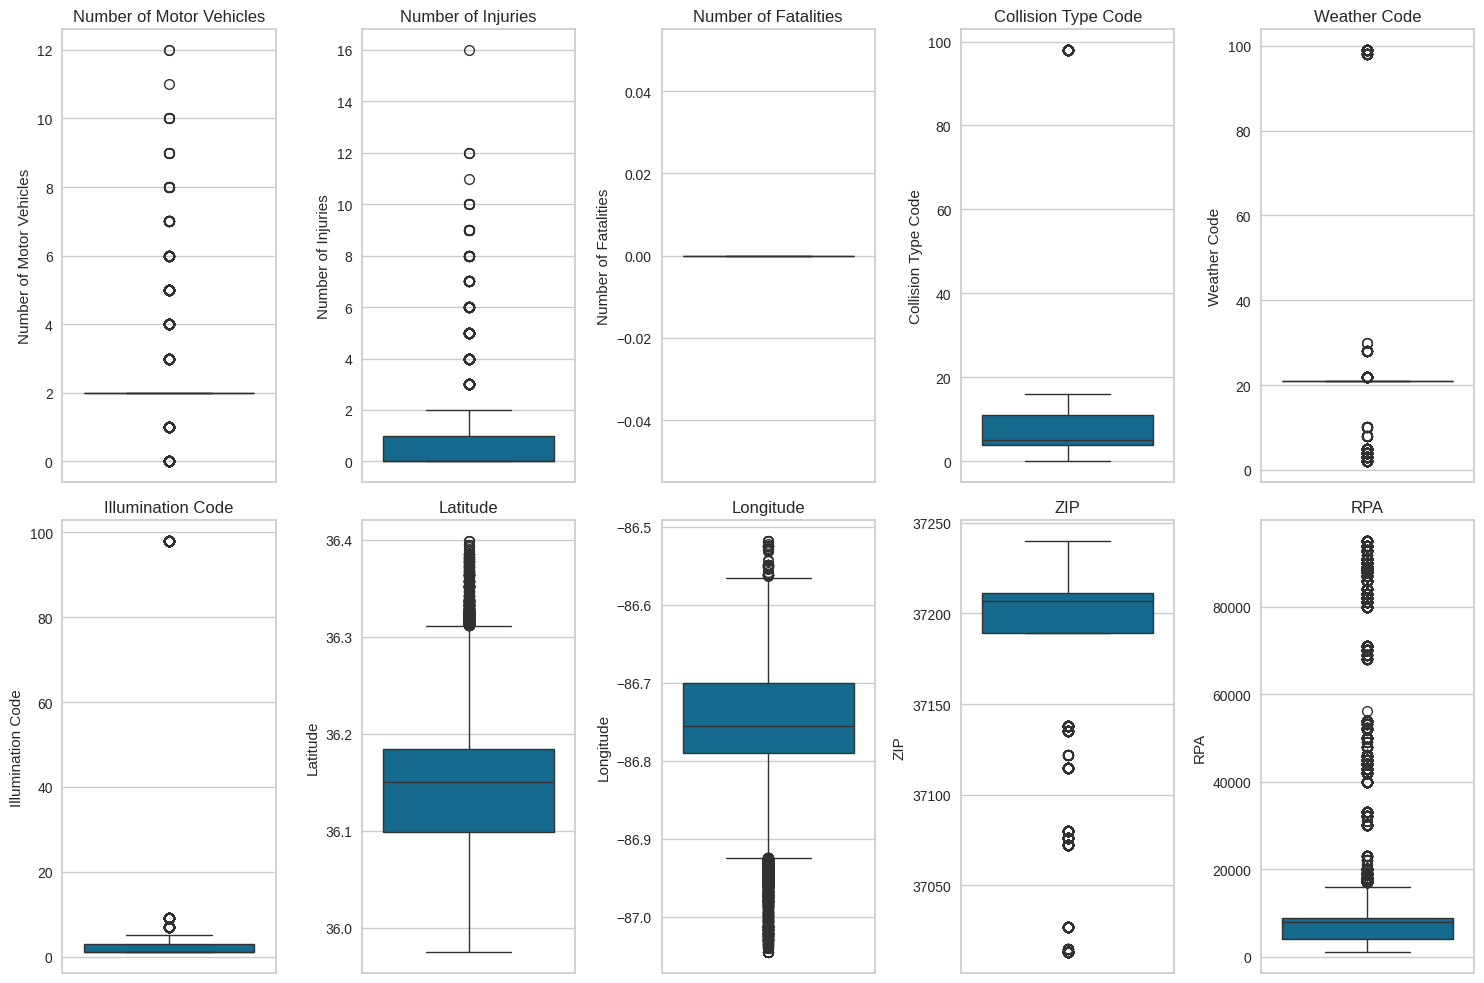

In [16]:
# Let's visualize boxplots for all of our features
fig, axs = plt.subplots(nrows=2, 
                        ncols=5, 
                        figsize=(15, 10))

# Let's flatten our axes to make it easier to iterate over
axs = axs.flatten()

# Put our boxplots into a 5x2 grid
for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], 
                ax=axs[i])
    axs[i].set_title(col)

# Display our boxplots
plt.tight_layout()
plt.show()

**Analysis**:

It seems that we can probably drop our Number of Fatalities.  

For some reason that data has not been recorded in any of our observations (also validated in the raw dataset).

In [17]:
# Let's drop our Number of Fatalities
df.drop('Number of Fatalities',
        axis=1,
        inplace=True)

#### 4.2. Correlation Heatmap

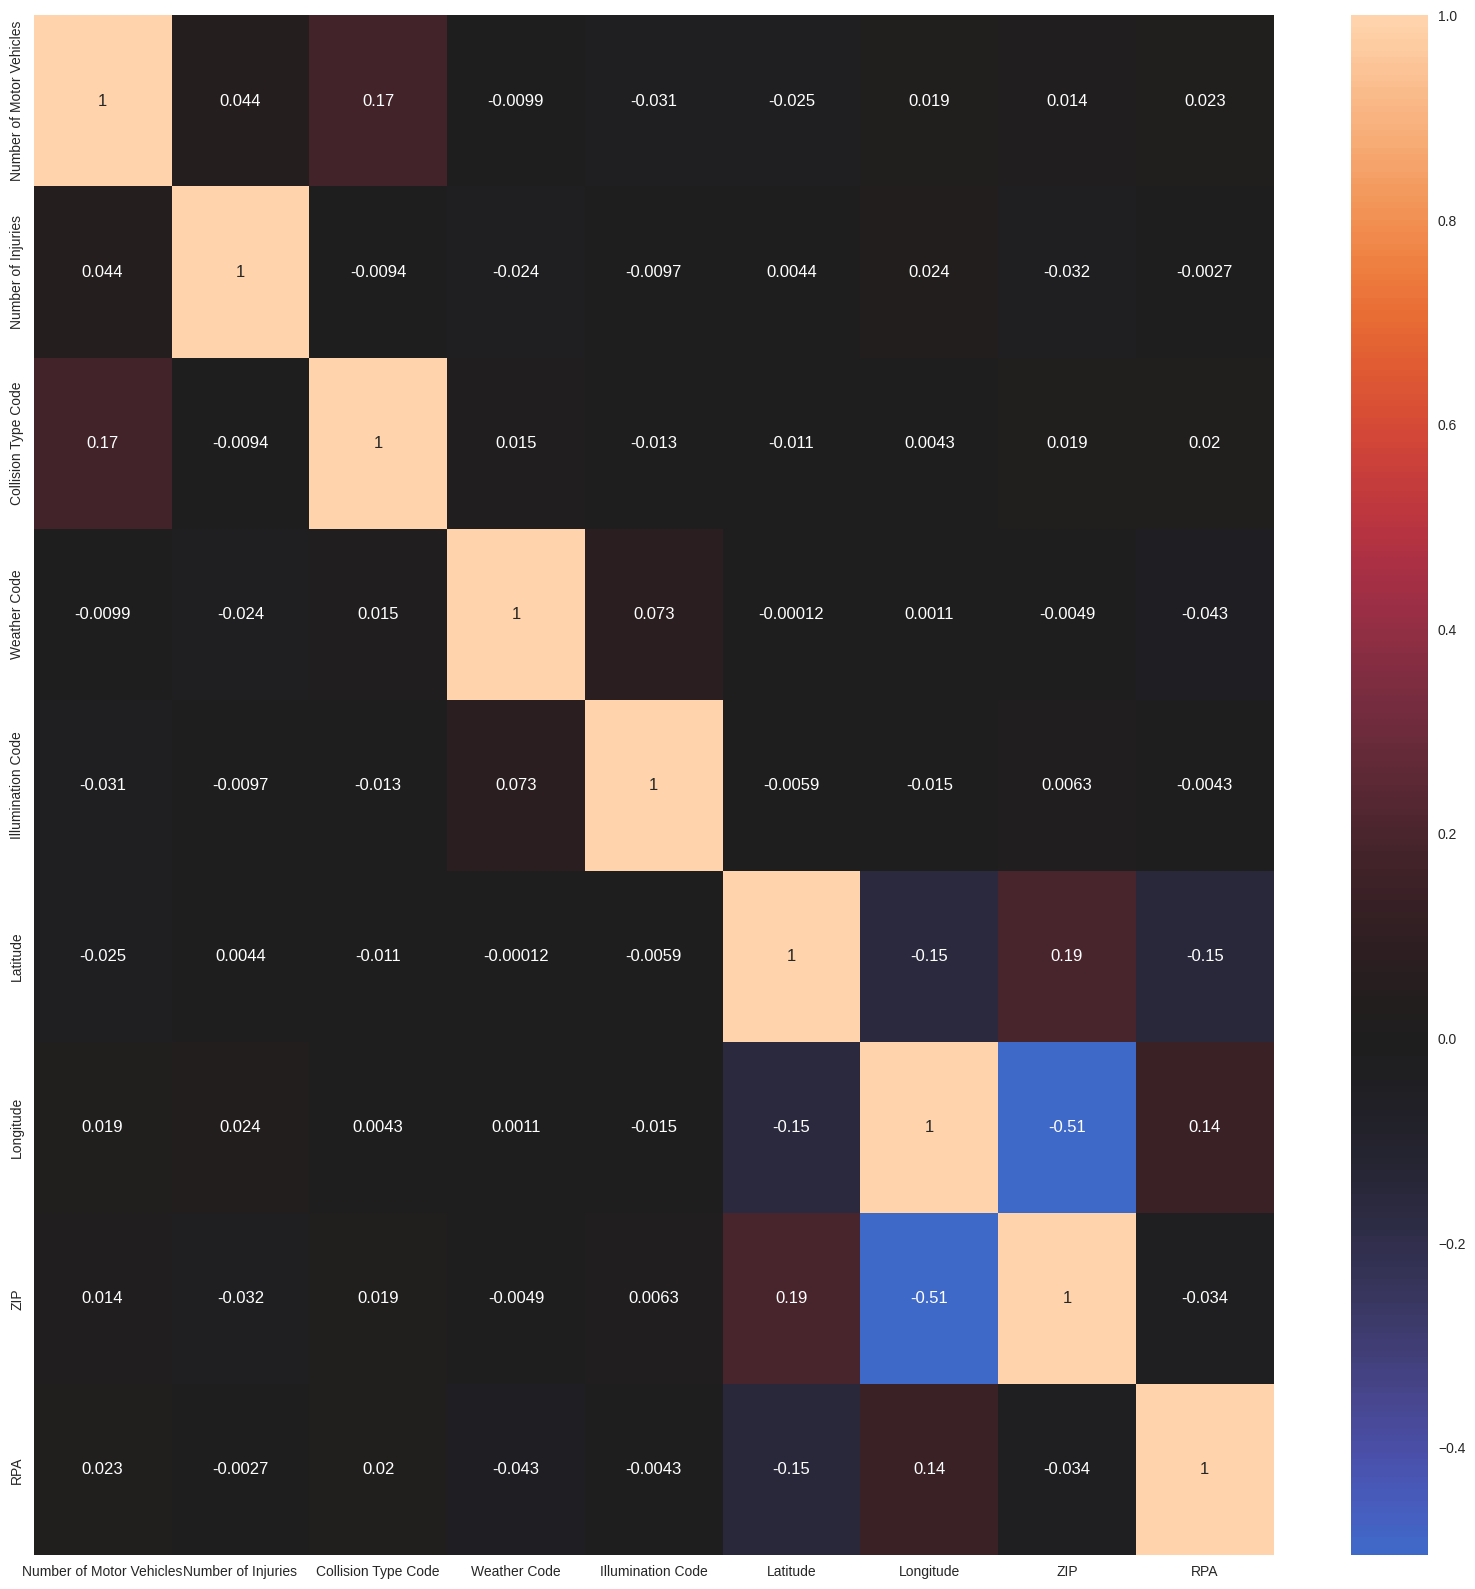

In [18]:
# Let's visualize correlations between our features
corrmat = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, 
            annot=True, 
            center=0)
plt.show()

**Analysis**:

Unsurprisingly, our geographical features such as Longitude, Latitude, and Zip code are all the most strongly correlated.

No other strong correlation stands out, however, in our dataset so far. Hopefully the clusters that we're deriving will add useful features into our dataset.

#### 4.3. Using the Elbow Method to Select 'K'

We need to select our starting value for `K`, which will tell our K-Means Clustering algorithm how many clusters to fit our data into.

To do this, we can use the `Elbow Method`:

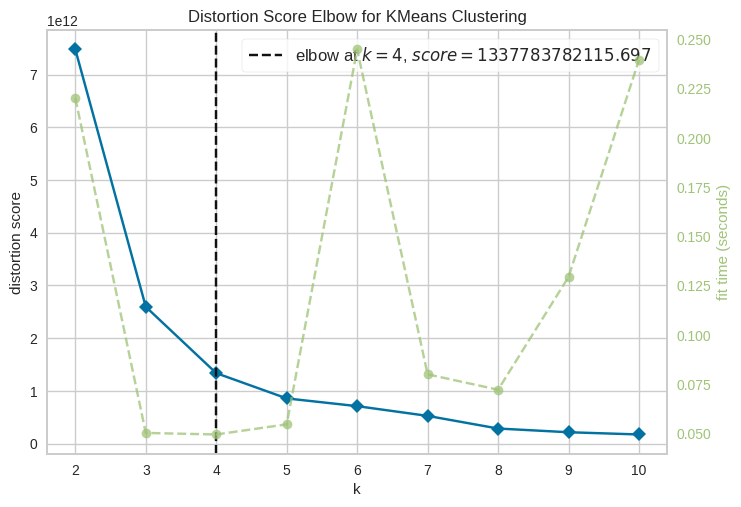

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Let's do an elbow visualization from k=2 to k=10
Elbow = KElbowVisualizer(KMeans(), k=10)
Elbow.fit(df)
Elbow.show()

**Analysis**:

As we can see, using the elbow method we get a value of `k = 4`.  

We'll use that as our starting point for clustering.

### 5. Model Creation
[top](#CSC-722:-Final-Project)

Now let's fit our K-Means Cluster model.

Remember that we don't have a target feature, nor do we need to do a train/test split.

In [20]:
# Fit our model, use k=4 as discovered above
KC = KMeans(n_clusters=4, random_state=42)
KMM = KC.fit_predict(df)

# Add y_pred back into our dataframe as a new column
df['Clusters'] = KMM

### 6. Results
[top](#CSC-722:-Final-Project)

#### 6.1. Visualize our Clusters

Text(0.5, 1.0, 'Distribution of Traffic Accident Clusters')

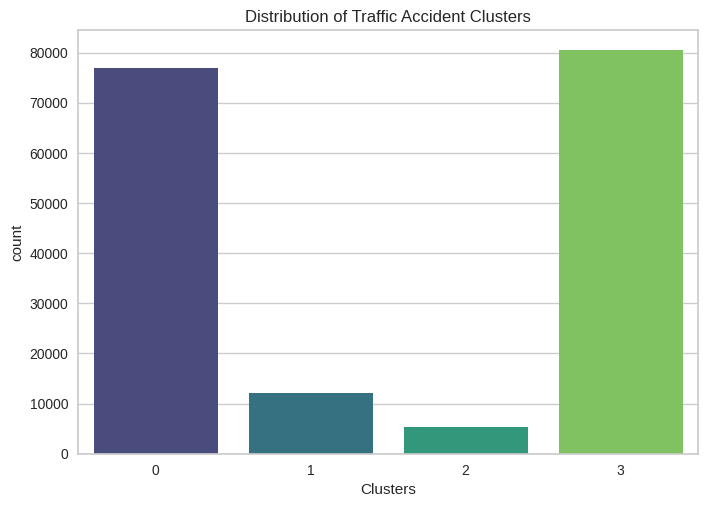

In [21]:
# Let's look at how much of each value is in each cluster
plt = sns.countplot(x=df['Clusters'], palette='viridis')
plt.set_title("Distribution of Traffic Accident Clusters")

**Analysis**:

Clusters 0 & 3 are pretty well matched for total count of observations.

Clusters 1 & 2 are similarly pretty well matched.

It'll be interesting to see after plotting these clusters onto a map what exactly they represent.

#### 6.2. Re-evaluating Correlation with Clusters

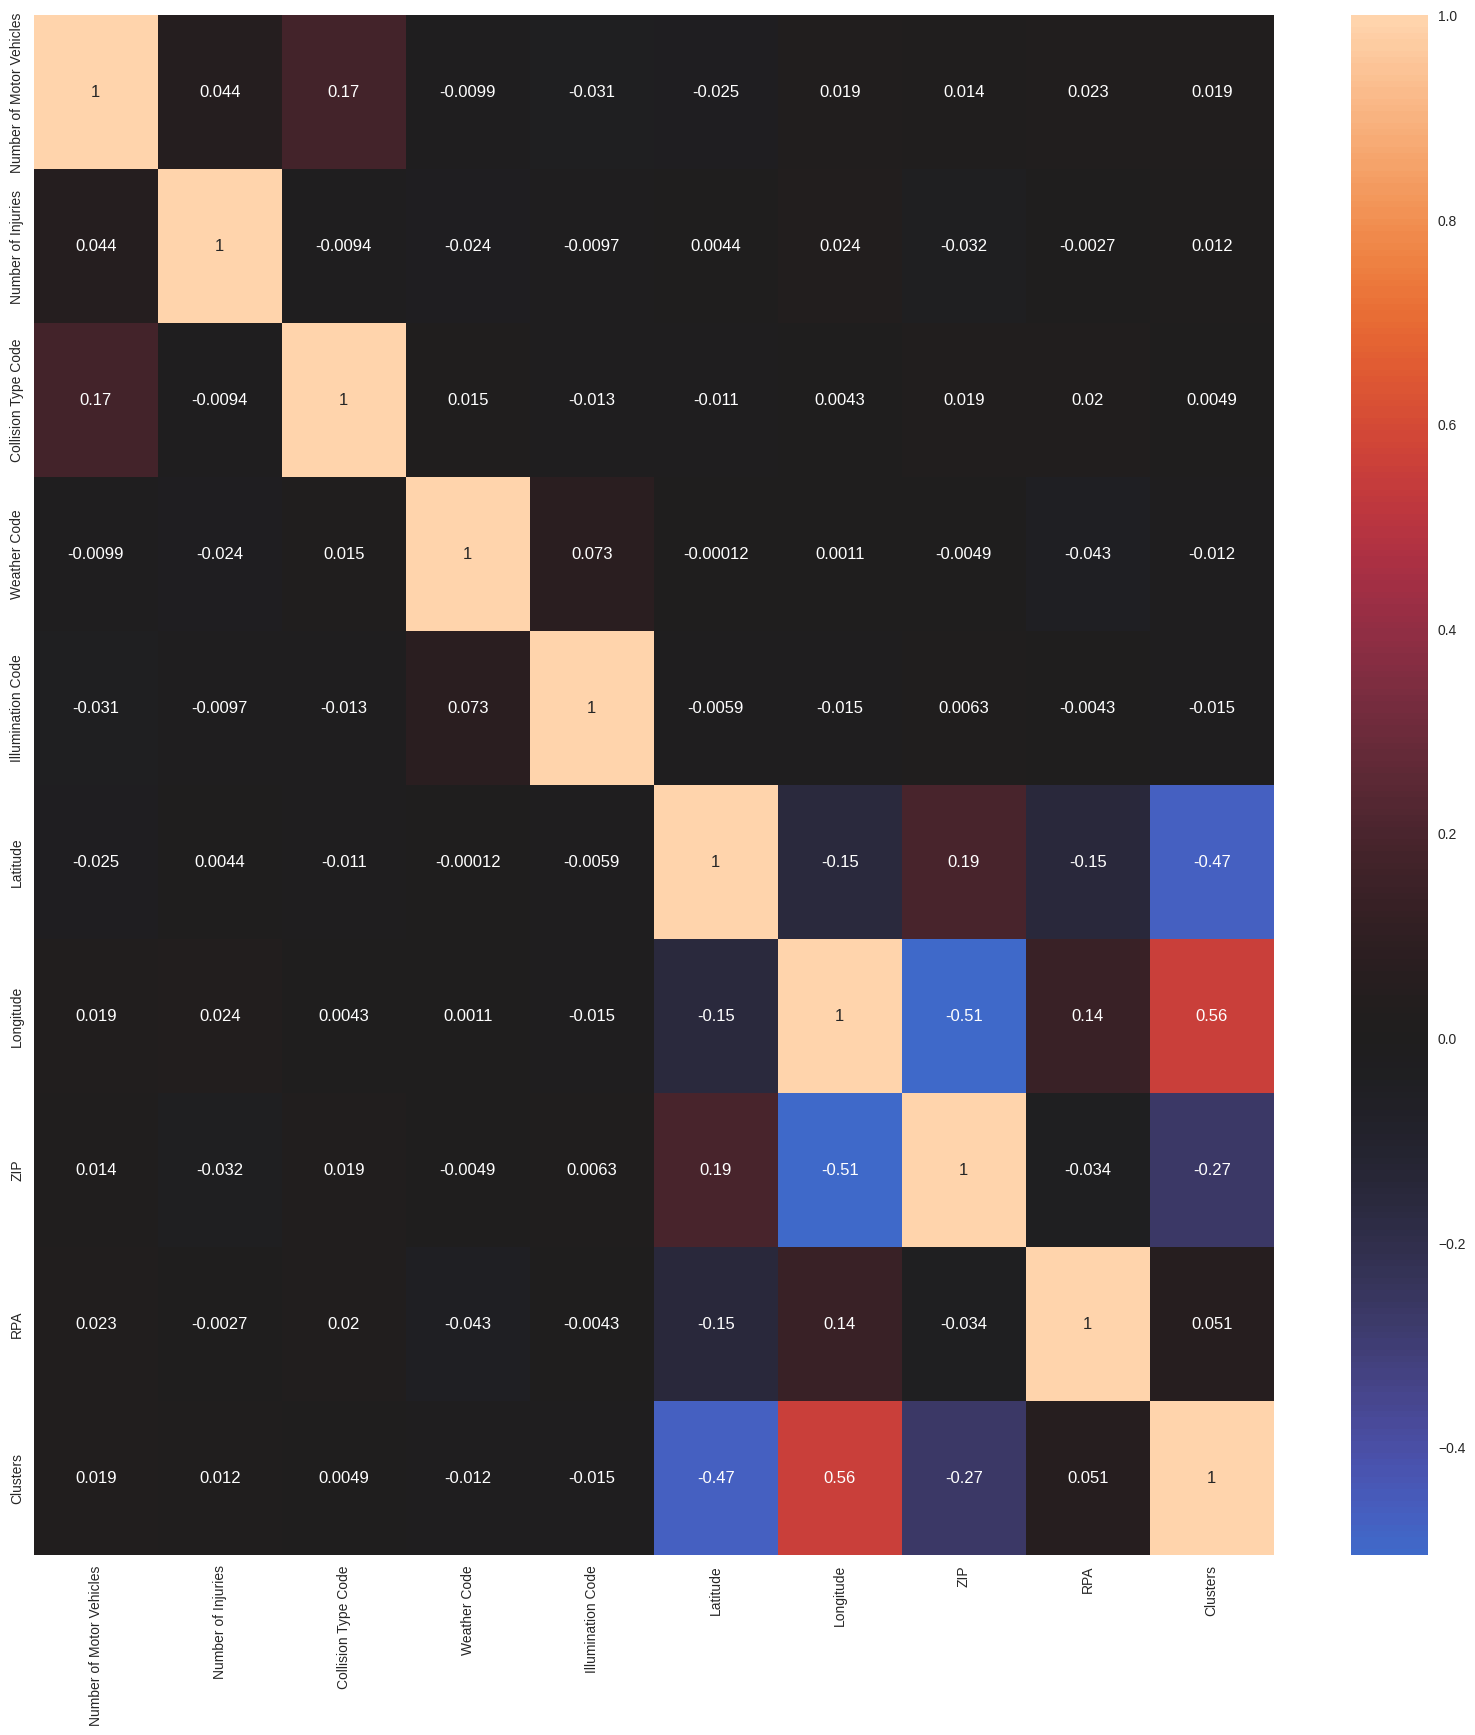

In [22]:
# Let's visualize correlations between our features
import matplotlib.pyplot as plt # For some reason I have to reinitialize matplotlib after having used it previously in earlier steps.
%matplotlib inline
corrmat = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, 
            annot=True, 
            center=0)
plt.show()

**Analysis**:

Interestingly, from the correlation map above it seems we may have clustered on geographical features. 

Our clusters have a decently strong correlation with Latitude, Longited, Zip code, and Reporting Police Precinct.

#### 6.3. KDE Plots

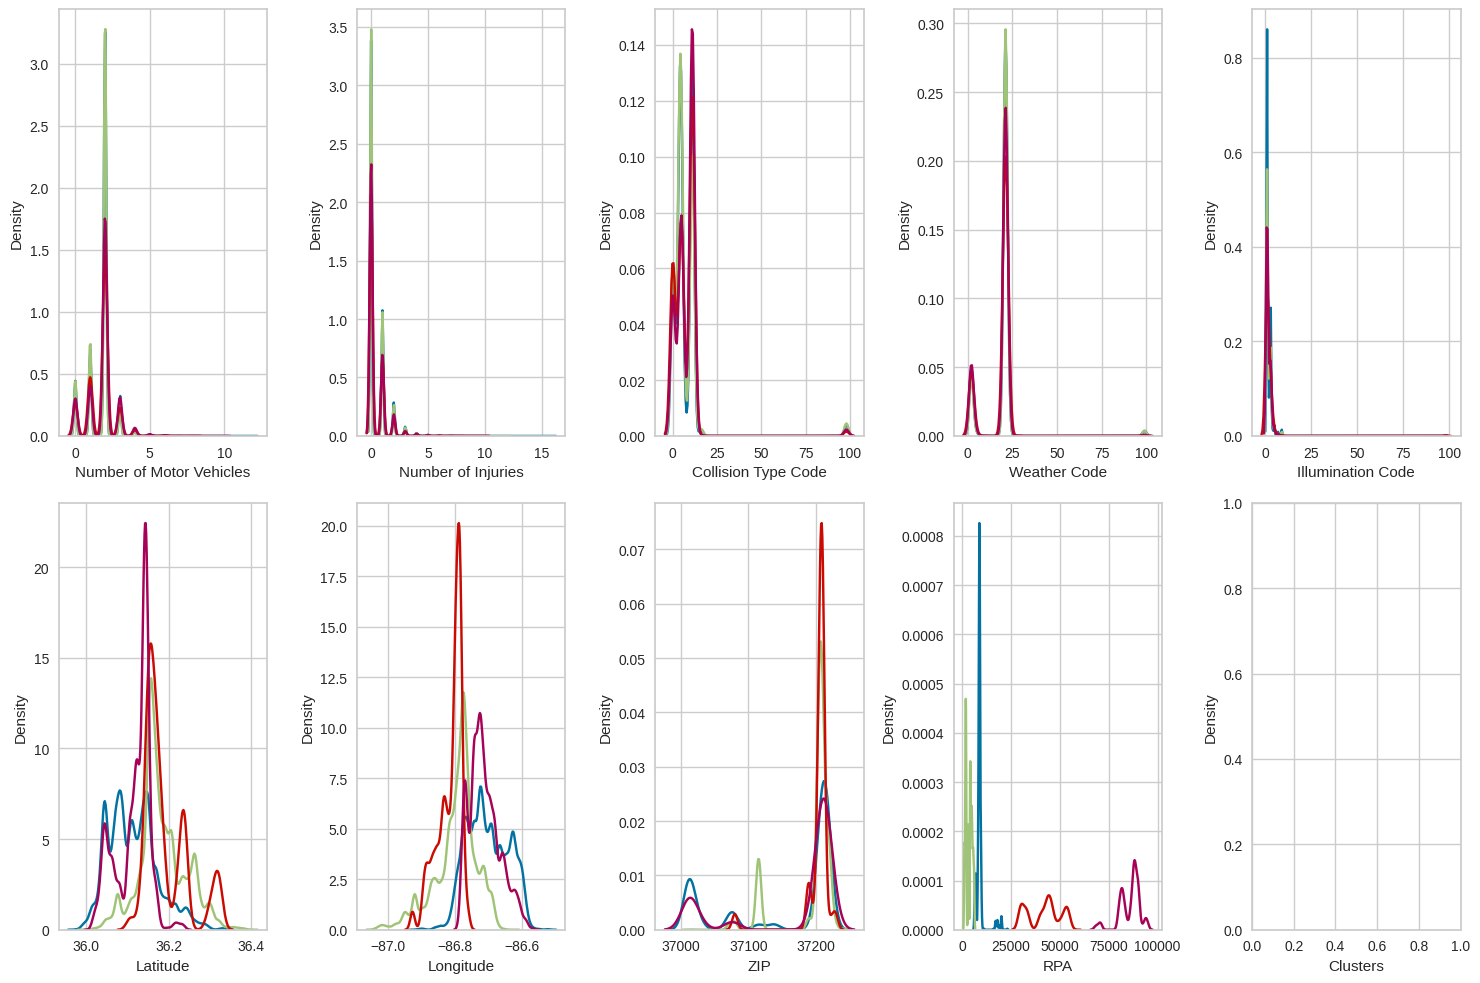

In [23]:
# Let's visualize KDE plots for all of our features
import matplotlib.pyplot as plt # For some reason I have to reinitialize matplotlib after having used it previously in earlier steps.
%matplotlib inline
# Let's visualize boxplots for all of our features
fig, axs = plt.subplots(nrows=2, 
                        ncols=5, 
                        figsize=(15, 10))

# Create our KDE plots in a 5x2 grid
for i,feature in enumerate(df.columns):
    row = i//5
    col = i%5
    for cluster in df['Clusters'].unique():
        sns.kdeplot(df[df['Clusters']==cluster][feature], 
                    ax=axs[row, col], 
                    label=f'Cluster: {cluster}')

# Display our plots
plt.tight_layout()
plt.show()

**Analysis**:

Matching our observations from the correlation heatplot, our KDE plots also show a clear separation in our clusters in the Zip code and Reporting Police Precinct (RPA).

It seems we clustered strongly on geolocation.

Let's visualize our clusters on a map next to see if that hypothesis holds true.

#### 6.4. Time for Some GeoPandas Mapping!

A set of Nashville-area map shape files have been downloaded from Nashville's Open Data Portal [3] that we'll use to overlay our clusters on top of.

Let's use it with GeoPandas to do some mapping of our clusters. [4]

In [24]:
# Load our Nashville map shape file into a GeoPandas dataframe
nashville_map = gpd.read_file('Nashville-Map.shp')

<Axes: >

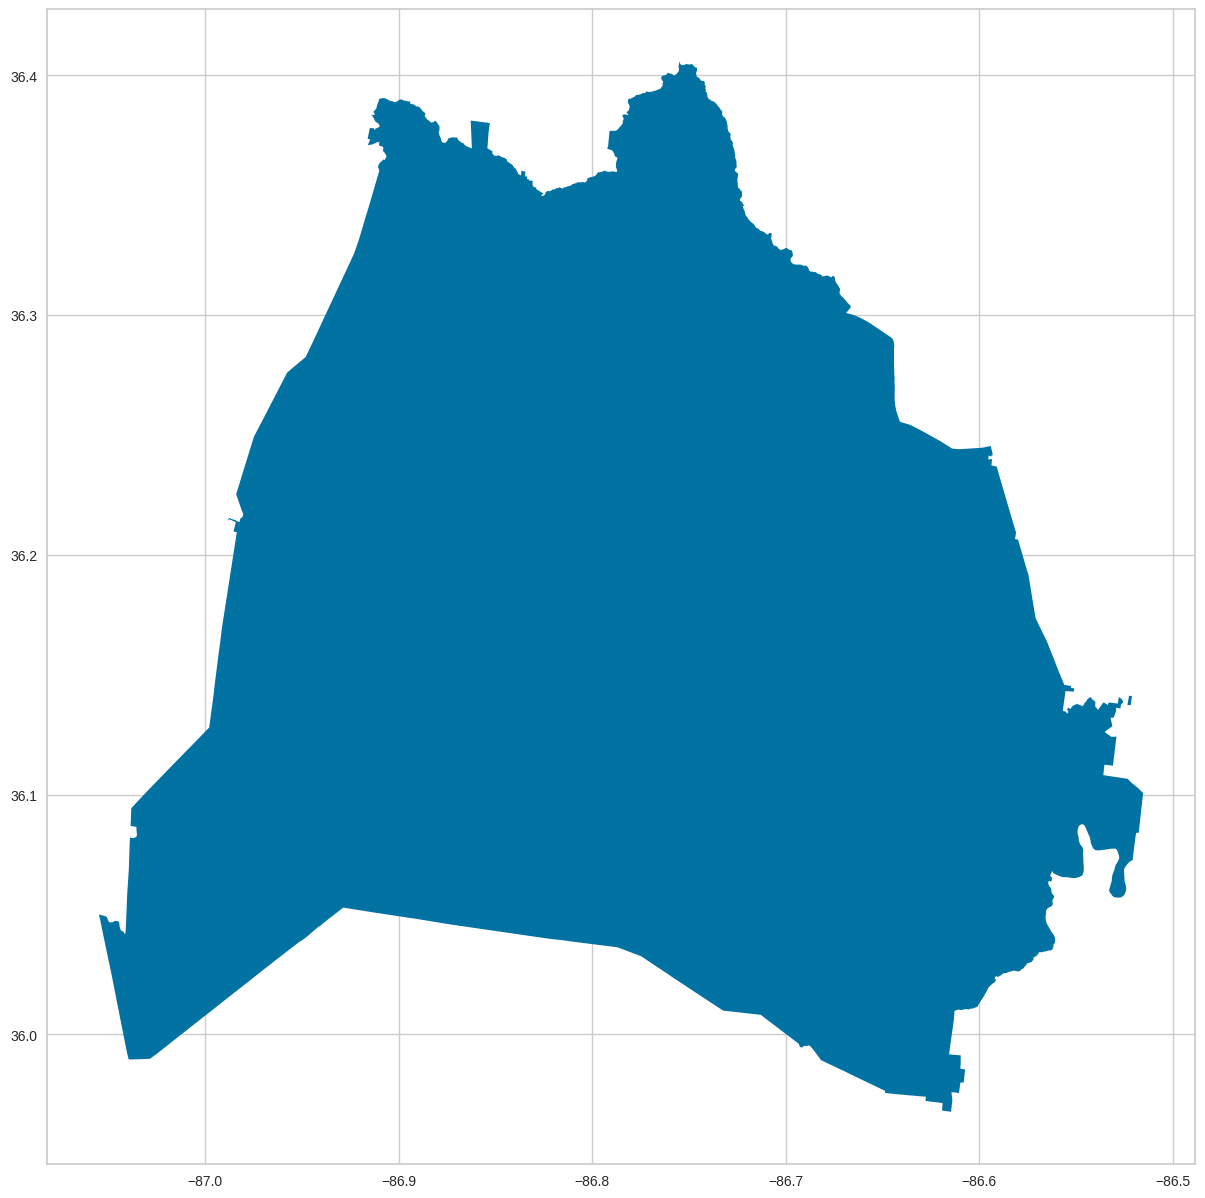

In [25]:
# Make sure we can load and display our map ok
import matplotlib.pyplot as plt # For some reason I had to reinitialize matplotlib after having used it previously in earlier steps.
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15))
nashville_map.plot(ax=ax)

In [26]:
# Get the geometry of our original dataframe points for plotting on a map
# This is why we kept the Latitude and Longitude features at the beginning of the notebook
geometry = [Point(xy) for xy in zip(df['Longitude'], 
                                    df['Latitude'])]

In [27]:
# Initialize our coordinate reference system, EPSG 4326 is apparently the most common system
# Documentation here: http://geopandas.org/projections.html
crs = {'init':'EPSG:4326'}

In [28]:
# Let's create a GeoDataFrame from our original plain pandas dataframe
# Use the coordinate system specified above as well as the geometry pulled from our original dataframe
geo_df = gpd.GeoDataFrame(df,
                          crs=crs,
                          geometry=geometry)

In [29]:
# Let's make sure our GeoPandas dataframe has data in it:
geo_df.head()

Number of Motor Vehicles  Number of Injuries  Collision Type Code  \
0                         2                   0                    4   
1                         2                   0                   11   
2                         2                   0                    5   
3                         2                   0                    5   
4                         2                   1                    4   

   Weather Code  Illumination Code  Latitude  Longitude    ZIP   RPA  \
0            21                  3   36.0455   -86.7122  37013  8757   
1            21                  1   36.1343   -86.7806  37204  6919   
2            22                  1   36.1208   -86.8029  37212  6506   
3            22                  1   36.1092   -86.7698  37204  8504   
4            22                  1   36.1343   -86.7806  37204  6919   

   Clusters                    geometry  
0         3  POINT (-86.71220 36.04550)  
1         3  POINT (-86.78060 36.13430)  
2         3  POINT (-86.80290 36.12080)  
3         3  POINT (-86.76980 36.10920)  
4         3  POINT (-86.78060 36.13430)

In [30]:
# Let's see how many records we have
geo_df.shape

(174811, 11)

**Analysis**:

We still have over `174,000`+ observations that we're going to be plotting.

This may take some time to generate our maps.  :-)

<Axes: >

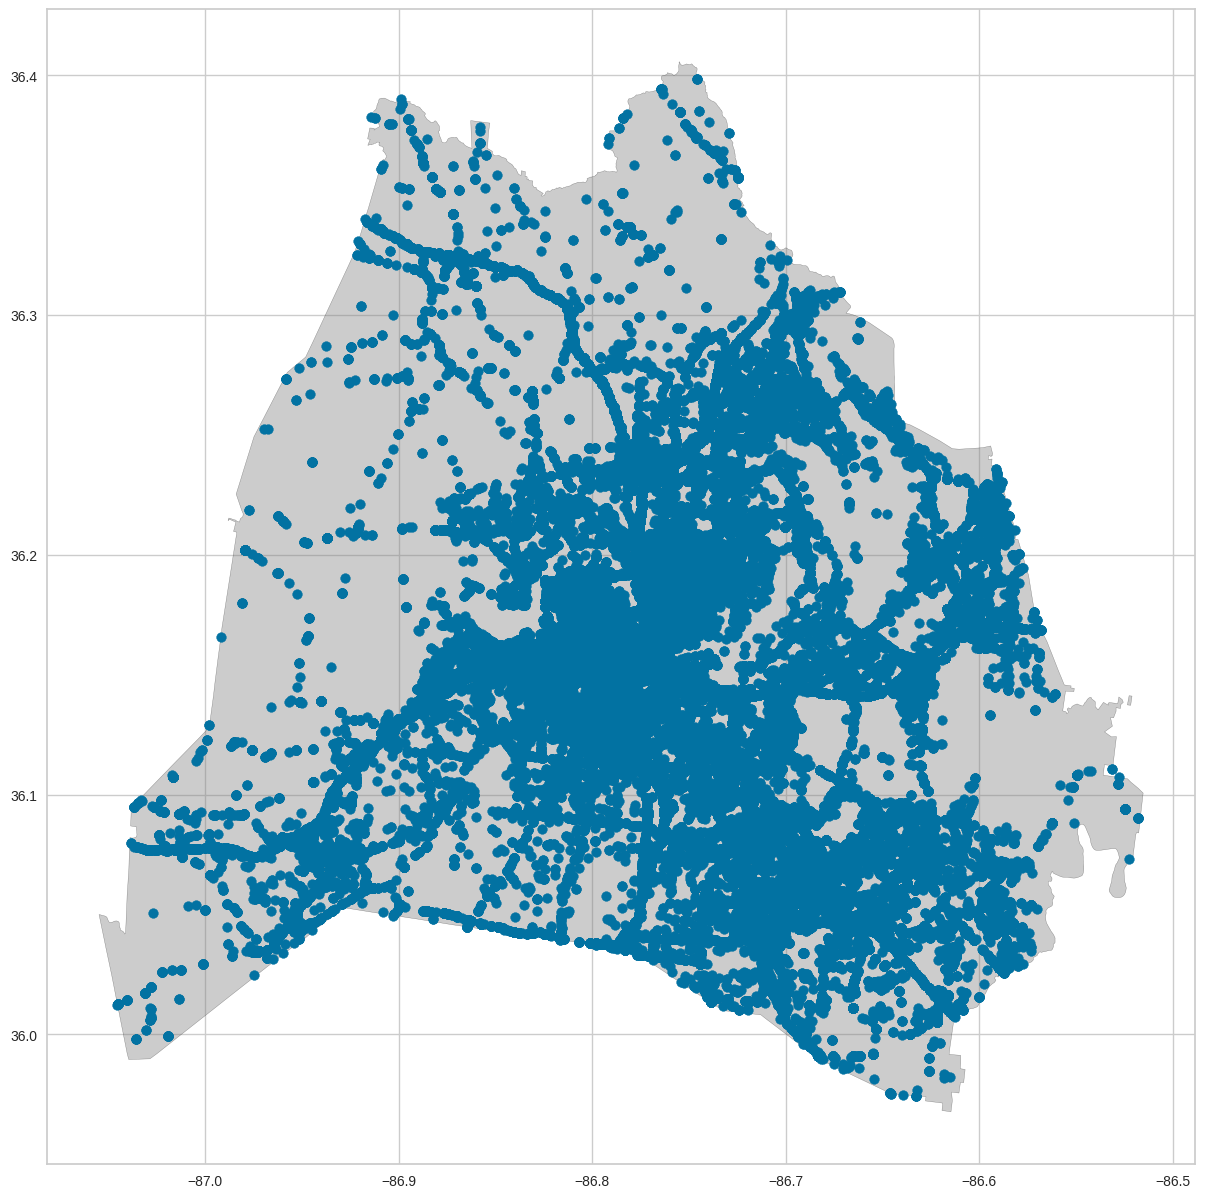

In [31]:
# Now let's map our unclustered data onto our geographical map just to make sure it works
fig, ax = plt.subplots(figsize=(15,15))
nashville_map.plot(ax=ax, 
                   alpha=0.4, 
                   color='grey', 
                   edgecolor='black')
geo_df.plot(ax=ax)

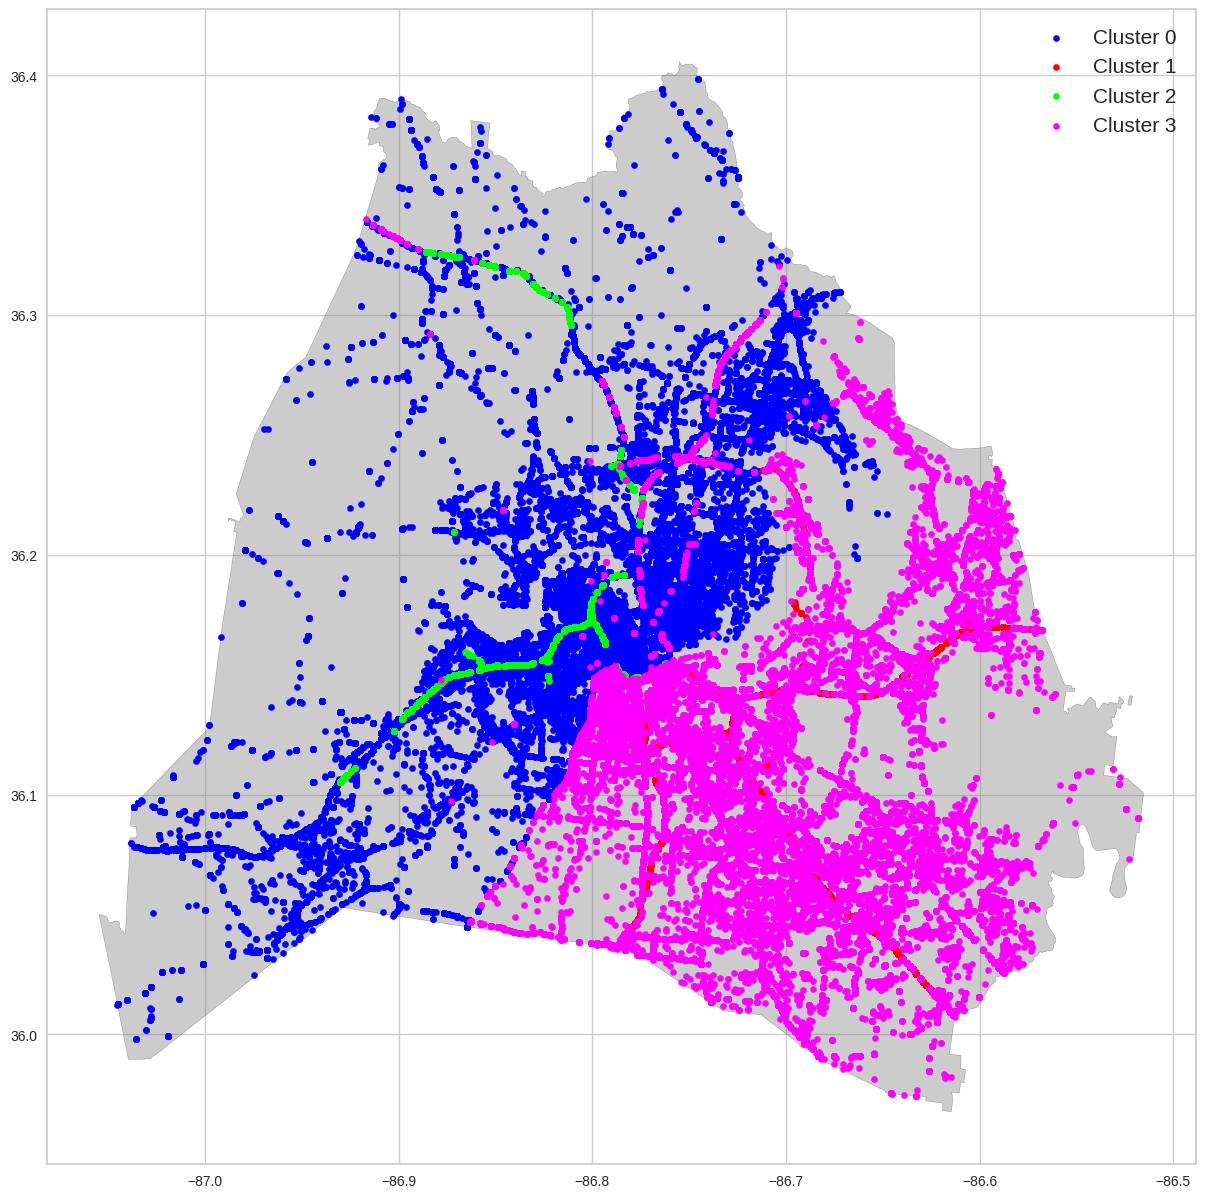

In [32]:
# Now let's map our clusters onto our geographical map
fig, ax = plt.subplots(figsize=(15,15))
nashville_map.plot(ax=ax, 
                   alpha=0.4, 
                   color='grey', 
                   edgecolor='black')
geo_df[geo_df['Clusters'] == 0].plot(ax=ax, 
                                     markersize=20, 
                                     color='blue', 
                                     marker='o', 
                                     label='Cluster 0')
geo_df[geo_df['Clusters'] == 1].plot(ax=ax, 
                                     markersize=20, 
                                     color='red', 
                                     marker='o', 
                                     label='Cluster 1')
geo_df[geo_df['Clusters'] == 2].plot(ax=ax, 
                                     markersize=20, 
                                     color='lime', 
                                     marker='o', 
                                     label='Cluster 2')
geo_df[geo_df['Clusters'] == 3].plot(ax=ax, 
                                     markersize=20, 
                                     color='magenta', 
                                     marker='o', 
                                     label='Cluster 3')
plt.legend(prop={'size':15})
plt.show()

**Analysis**:

Some clear patterns are emerging in our map.  For example, the Red cluster clearly follows an Interstate system in Nashville.

The Magenta and Blue clusters divide up most of the secondary roads in Nashville, seemingly partitioned at a diagonal from southwest to northeast, right across the center of Downtown Nashville.

The Green cluster is hard to see here, so next we'll break out each individual cluster to further analyze.

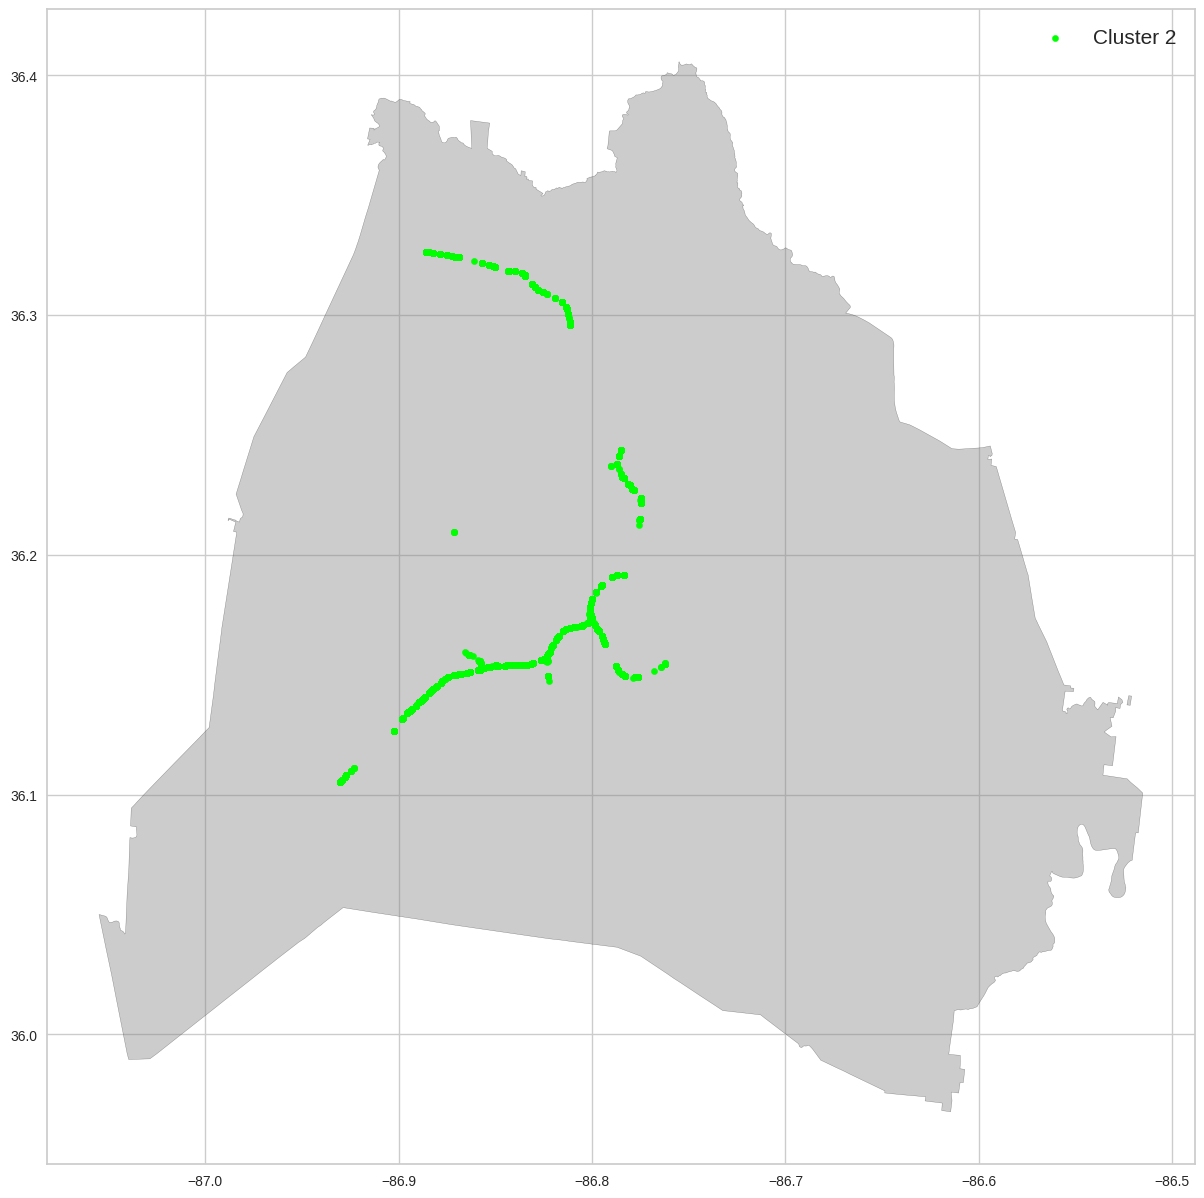

In [33]:
# The Lime Green cluster is difficult to see, let's plot just that one:
fig, ax = plt.subplots(figsize=(15,15))
nashville_map.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
geo_df[geo_df['Clusters'] == 2].plot(ax=ax, 
                                     markersize=20, 
                                     color='lime', 
                                     marker='o', 
                                     label='Cluster 2')
plt.legend(prop={'size':15})
plt.show()

**Analysis**:

Interestingly, this Lime Green cluster seems to follow  the western part of Interstate 40 and northern portions of Interstate 24.

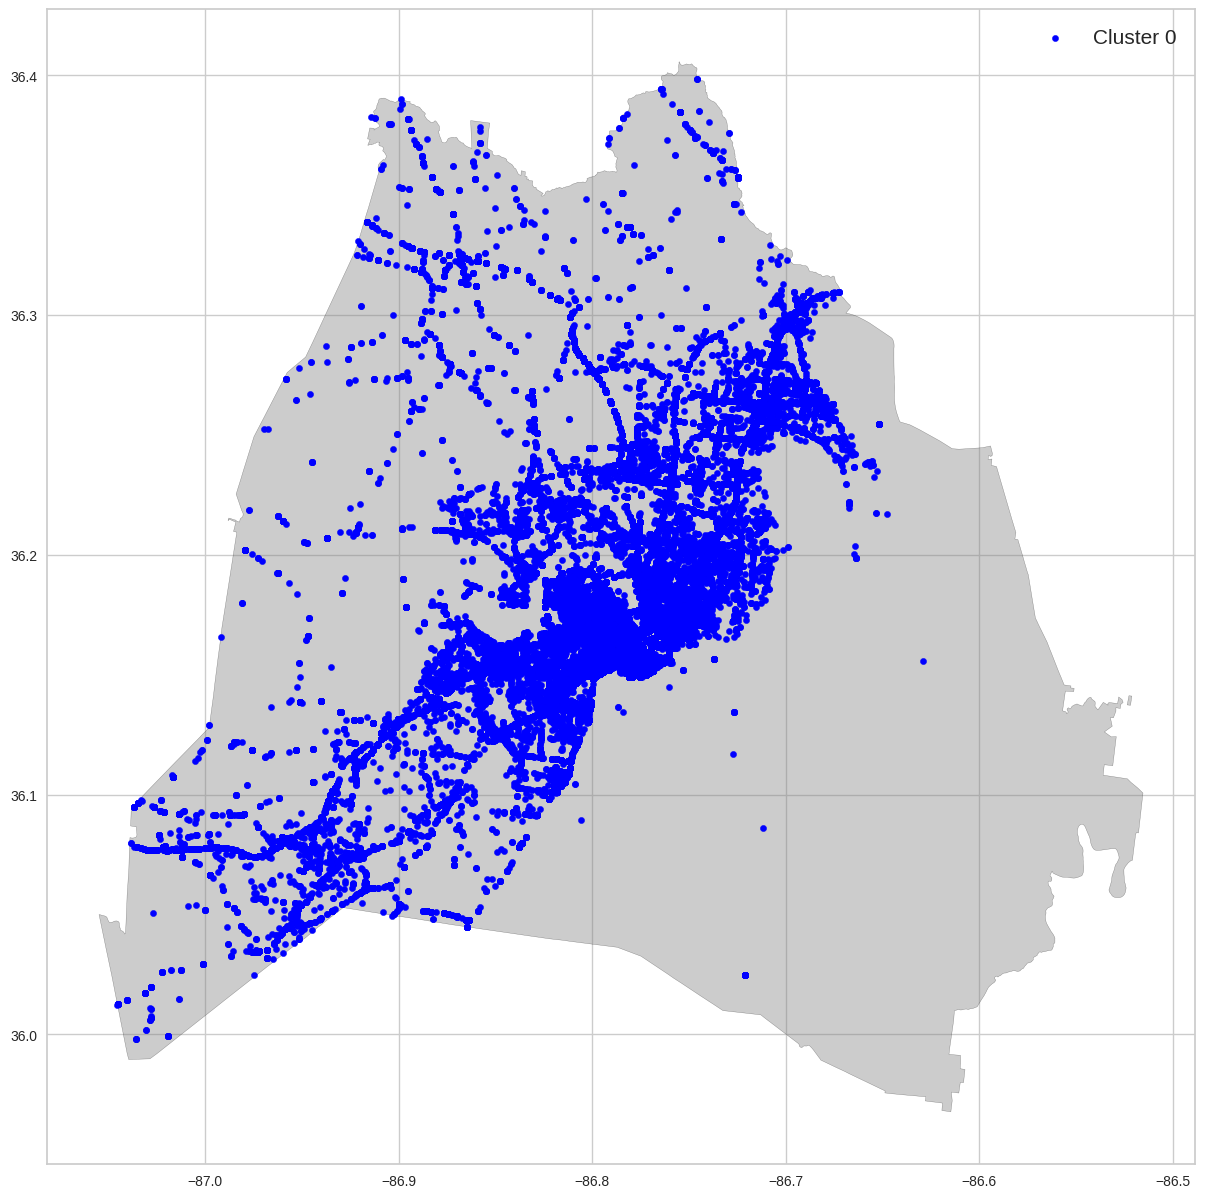

In [34]:
# Let's look more closely at just the Blue cluster
# Now let's map our clusters onto our geographical map
fig, ax = plt.subplots(figsize=(15,15))
nashville_map.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
geo_df[geo_df['Clusters'] == 0].plot(ax=ax, 
                                     markersize=20, 
                                     color='blue', 
                                     marker='o', 
                                     label='Cluster 0')
plt.legend(prop={'size':15})
plt.show()

**Analysis**:

This cluster accounts for most of southeastern Nashville and portions of northern Interstate 65.

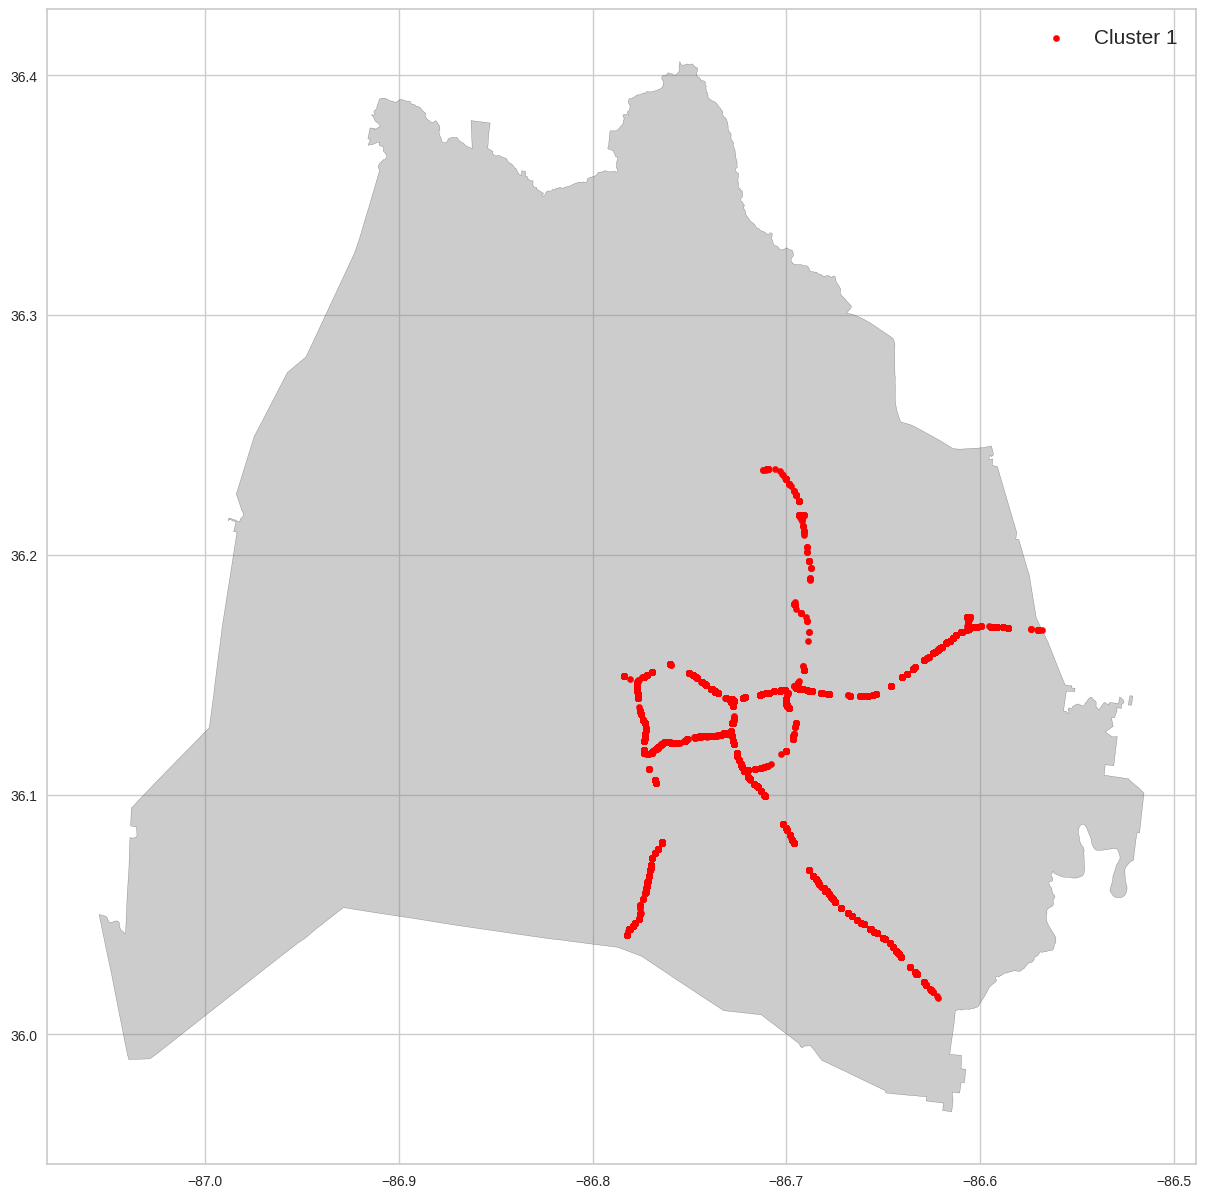

In [35]:
# Let's look at just the red cluster
fig, ax = plt.subplots(figsize=(15,15))
nashville_map.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
geo_df[geo_df['Clusters'] == 1].plot(ax=ax, 
                                     markersize=20, 
                                     color='red', 
                                     marker='o', 
                                     label='Cluster 1')
plt.legend(prop={'size':15})
plt.show()

**Analysis**:

This cluster is very clearly the Interstate systems around southeastern Nashville.

It follows portions of Interstate 24, Interstate 65, Interestate 40, and downtown loop Interstate 440.

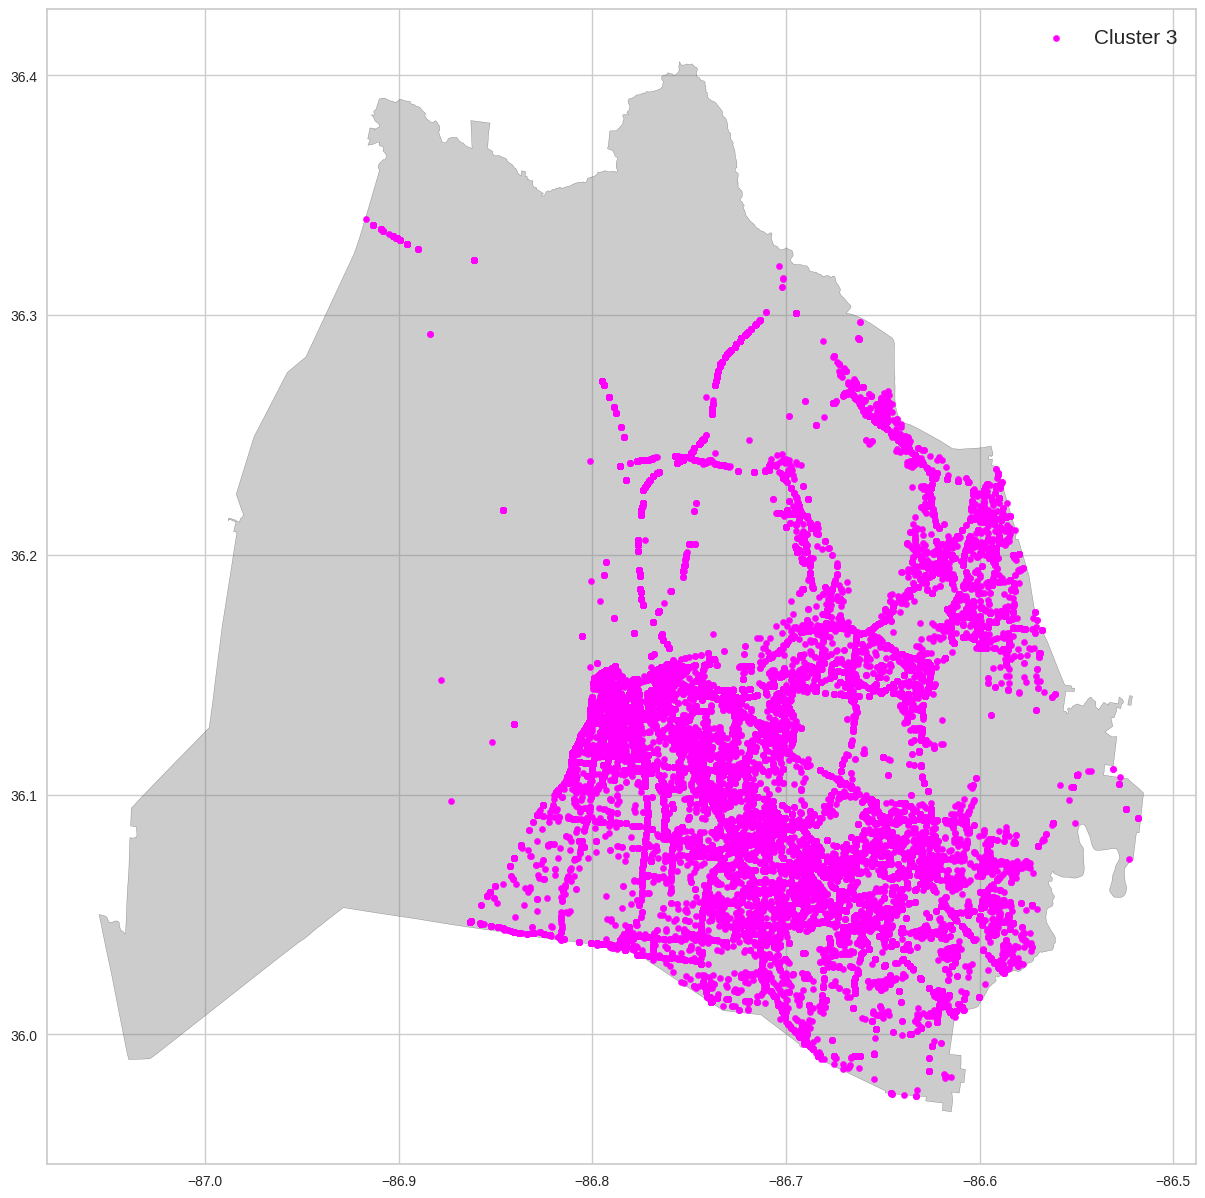

In [36]:
# Let's look at just the magenta cluster
fig, ax = plt.subplots(figsize=(15,15))
nashville_map.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
geo_df[geo_df['Clusters'] == 3].plot(ax=ax, 
                                     markersize=20, 
                                     color='magenta', 
                                     marker='o', 
                                     label='Cluster 3')
plt.legend(prop={'size':15})
plt.show()

**Analysis**:

This cluster is mainly accidents in the northwestern half of Nashville.  While it includes parts of the Interstate system, it mainly mainly includes secondary roads.

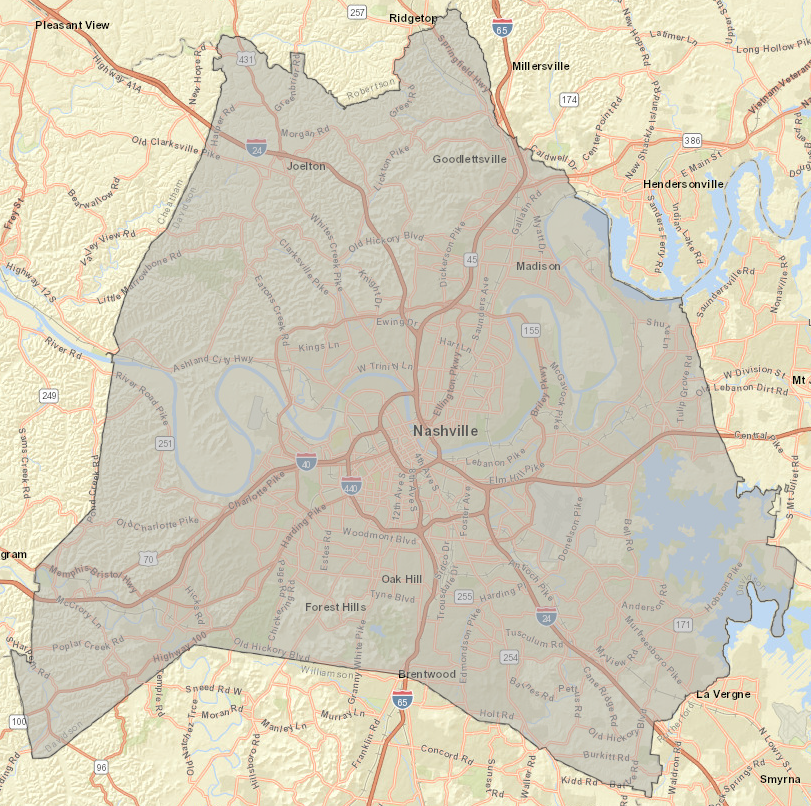

In [37]:
# For reference, this is a map of Nashville with major roads and interstates included:
Image(filename='Nashville-Map.png')

### 7. Discussion
[top](#CSC-722:-Final-Project)

We ended up with 4 separate clusters of accidents.  Based off the map data and domain knowledge of the Nashville interstate system, we can roughly categorize the clusters like this:
* **Cluster 0** (Blue): The Southeastern half of Nashville, split at a diagonal roughly along Interstate 65 & Interstate 40.  This cluster accounts for the majority of the secondary roads in this map area.
* **Cluster 1** (Red): The Southeastern interstates, including Interestate 24, Interstate 65, and Interstate 40 all South & East of Downtown Nashville
* **Cluster 2** (Green): Most of the Northwestern interstates, including Interstate 40 and Interstate 65/24 North & West of Downtown Nashville
* **Cluster 3** (Magenta): The Northwestern half of Nashville, split at a diagonal roughly along Interstate 65 & Interstate 40.  Accounts for the majority of secondary roads in this map area.

**Clustering Criteria**:

It seems that our model clustered on two main criteria:
1. secondary roads vs. Interstate highways 
2. an imaginary line partitioning the Southeastern vs. Northwestern half of the city

We can definitely see hotspots of accidents along interstate corridors, enough so that 2 of our 4 clusters seem to be primarly just interstates (and from personal experience, the busiest sections of the busiest interstates).  That tracks logically that there would be a high volume of accidents on these particular stretches of road.

**Future Projects/Research**:

While we didn't make any predictions with this dataset, now that we have these 4 clusters a future project of interest may be using them as a target feature for additional analysis. 

Some possibile projects and research topics making use of these clusters could include:
* The affects of weather on accidents (is there a part of the city or certain roads where weather has a more significant impact on accident prevalence or severity?)
* The affects of date/time on accidents (do more accidents happen during rush hour, or overnight, or maybe on specific days?)
* The affects of external illumination on accidents (does having external illumination seem to result in fewer or less severe accidents?
    * This could be useful for the city and Tennessee's Department of Transportation to understand whether or not investing in illumination infrastructure is a good investment for safety.)

### 8. Citations
[top](#CSC-722:-Final-Project)

**References**:

- [1] “Traffic Accidents | Nashville Open Data Portal.” Accessed: March 31, 2024. [Online]. Available: https://data.nashville.gov/Police/Traffic-Accidents/6v6w-hpcw/about_data
- [2] “Traffic Accidents Metadata | Nashville Open Data Portal.” Accessed: March 31, 2024. [Online]. Available: https://data.nashville.gov/api/views/6v6w-hpcw/files/3af9281b-fa4f-4044-83f8-1b9a46cc6e95?download=true&filename=Traffic-Accidents-Metadata-v2.pdf
- [3] “Davidson County Border (GIS) | Nashville Open Data Portal,” Metropolitan Government of Nashville and Davidson County, Tennessee. Accessed: Dec. 01, 2023. [Online]. Available: https://data.nashville.gov/General-Government/Davidson-County-Border-GIS-/whcy-hmdk
- [4] R. Stewart, “GeoPandas 101: Plot any data with a latitude and longitude on a map,” Medium. Accessed: Nov. 30, 2023. [Online]. Available: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972